# Running Spectral Fitting

Fitting spectral methods on simulated power spectra.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats.mstats import normaltest

from fooof.sim import gen_power_spectrum, gen_group_power_spectra

In [2]:
# Import custom code
import sys; from pathlib import Path
sys.path.append(str(Path('..').resolve()))

from apm.fit import *
from apm.fake import SimFits, print_res
from apm.plts import plot_psds, plot_psds_two
from apm.plts.utils import color_red_or_green

from apm.core.db import APMDB
from apm.core.io import save_pickle, load_pickle

from apm.sim.peaks import *

### Editorial Note

Still some work to do here to check the simulation code and make sure everything is updated properly. 

In [3]:
# OLD:
from apm.sim.peaks import _check_duplicate
CEN_FREQS = np.load('/Users/tom/Documents/GitCode/AperiodicMethods/apm/sim/data/freqs.npy')
PROBS = np.load('/Users/tom/Documents/GitCode/AperiodicMethods/apm/sim/data/probs.npy')

def gen_osc_def(n_oscs=None):
    """Generate a plausible oscillation distribution for a synthetic PSD.
    Parameters
    ----------
    n_oscs : int, optional
        Number of oscillations to generate. If None, picked at random. Default: None.
    Returns
    -------
    oscs : list of list of [float, float, float], or []
        Oscillation definitions.
    """

    #
    if n_oscs is None:
        n_oscs = np.random.choice([0, 1, 2], p=[1/3, 1/3, 1/3])

    # Initialize list of oscillation definitions
    oscs = []

    # Define the power and bandwidth possibilities and probabilities
    pow_opts = [0.05, 0.10, 0.15, 0.20]
    pow_probs = [0.25, 0.25, 0.25, 0.25]
    bw_opts = [1, 1.5, 2]
    bw_probs = [1/3, 1/3, 1/3]

    # Generate oscillation definitions
    for osc in range(n_oscs):

        cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

        while _check_duplicate(cur_cen, [it[0] for it in oscs]):
            cur_cen = np.random.choice(CEN_FREQS, p=PROBS)

        cur_amp = np.random.choice(pow_opts, p=pow_probs)
        cur_bw = np.random.choice(bw_opts, p=bw_probs)

        oscs.append([cur_cen, cur_amp, cur_bw])

    return oscs

### Setup & Settings

In [4]:
# Set up project database object
db = APMDB()

In [5]:
# General simulation settings
f_range = [3, 40]

off_val = 0

noise = 0.0

## Check out PSD generation and test fitting

In [6]:
# Generate a single simulated test power spectrum
exp_val = 1
peak_gen = gen_peak_def()

peaks = next(peak_gen)

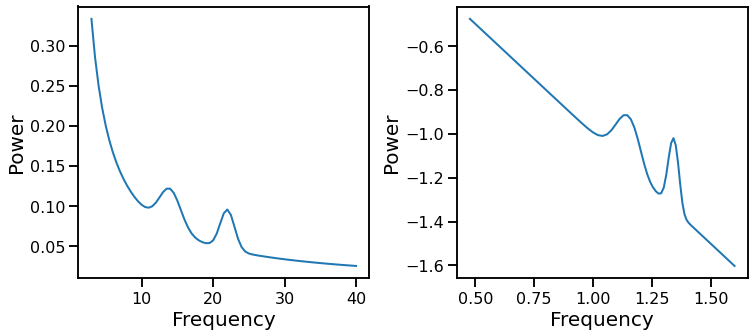

In [7]:
# Old version
fs, psd = sim_psd(f_range, exp_val, peaks, noise)
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(fs, psd, np.log10(fs), np.log10(psd))

In [8]:
# Simulate an example power spectrum
fs, psd = gen_power_spectrum(f_range, [off_val, exp_val], peaks, noise)

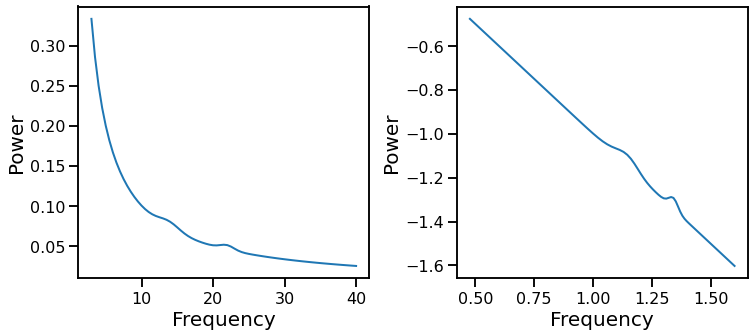

In [9]:
# Plot and check a simulated spectrum, plotted in semi-log and log space
plot_psds_two(fs, psd, np.log10(fs), np.log10(psd))

In [10]:
# Test out fits
print('True exponent value is ', str(exp_val), '\n')
print('OLS fit: \t', fit_ols(fs, psd))
print('RLM fit: \t', fit_rlm(fs, psd))
print('RLM-EA fit: \t', fit_rlm_alph(fs, psd))
print('RLM-EO fit: \t', fit_rlm_oscs(fs, psd))
print('RAN fit: \t', fit_ransac(fs, psd))
print('RAN-EA fit: \t', fit_ransac_alph(fs, psd))
print('RAN-EO fit: \t', fit_ransac_oscs(fs, psd))
print('EXP fit: \t', fit_exp(fs, psd))
print('EXP-EA fit: \t', fit_exp_alph(fs, psd))
print('EXP-EO fit: \t', fit_exp_oscs(fs, psd))
print('FOOOF fit: \t', fit_fooof(fs, psd))

True exponent value is  1 

OLS fit: 	 -1.0033812568656857
RLM fit: 	 -1.0006323377358153
RLM-EA fit: 	 -1.0001652080596204
RLM-EO fit: 	 -1.0000017151081606
RAN fit: 	 -1.0033812568656857
RAN-EA fit: 	 -1.0031025599698833
RAN-EO fit: 	 -1.0003220896839073
EXP fit: 	 -1.0033812574602508
EXP-EA fit: 	 -1.0031025608166226
EXP-EO fit: 	 -1.0003220905128827
FOOOF fit: 	 -1.0001338625412473


## Run a Fits on Simulated Power Spectra

In [11]:
# Settings
n_psds = 50
f_range = [3, 40]
exp_val = 1
noise = 0.05

In [12]:
# NEW VERSION.
freqs, psds, sim_params = gen_group_power_spectra(\
    n_psds, f_range, [off_val, exp_val], gen_peak_def(), noise, return_params=True)

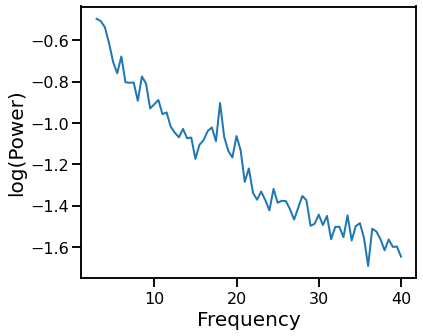

In [13]:
# Plot example simulated power spectrum from the group
plot_psds(freqs, psds[10, :])

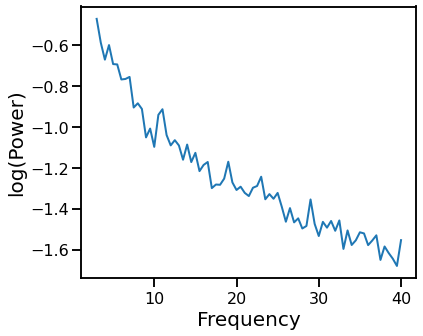

In [14]:
# OLD: Simulate a group of PSDs
freqs, psds = sim_n_psds(n_psds, f_range, exp_val, gen_osc_def, noise)
plot_psds(freqs, psds[:, 10])

In [15]:
# # Check out some of the simulated power spectra
# for ind, psd in enumerate(psds.T):
#     if ind < 5:
#         plt.figure()
#         plt.plot(freqs, psd)

In [16]:
# Initialize and set up for simulated data testing
sims = SimFits()
sims.get_fit_funcs()

In [17]:
# Check the fitting functions being used
print(list(sims.fit_funcs.keys()))

['OLS', 'OLS-EA', 'OLS-EO', 'RLM', 'RLM-EA', 'RLM-EO', 'RAN', 'RAN-EA', 'RAN-EO', 'EXP', 'EXP-EA', 'EXP-EO', 'FOOOF']


In [18]:
# Fit spectra: this fits all methods
sims.fit_spectra(exp_val, freqs, psds)

In [19]:
# Calculate metrics
avgs = sims.calc_avg_errs()
perc_good = sims.calc_perc_good()

In [20]:
# Check errors per fitting method
print('AVERAGE FIT ERRORS')
print_res(avgs)

AVERAGE FIT ERRORS
   RAN      		 0.01631
   RLM-EO   		 0.02156
   OLS-EO   		 0.02282
   EXP-EO   		 0.02282
   FOOOF    		 0.02331
   RLM      		 0.02386
   RAN-EO   		 0.02607
   RLM-EA   		 0.02644
   OLS-EA   		 0.02734
   EXP-EA   		 0.02734
   RAN-EA   		 0.02895
   OLS      		 0.02906
   EXP      		 0.02906


In [21]:
# Check errors per fitting method
print('PERCENTAGE FITS BELOW ERROR THRESHOLD')
print_res(perc_good)

PERCENTAGE FITS BELOW ERROR THRESHOLD
   RAN      		 0.60000
   FOOOF    		 0.56000
   RLM-EO   		 0.54000
   RLM      		 0.54000
   OLS-EO   		 0.54000
   EXP-EO   		 0.54000
   RLM-EA   		 0.48000
   RAN-EO   		 0.48000
   OLS      		 0.48000
   EXP      		 0.48000
   RAN-EA   		 0.46000
   OLS-EA   		 0.44000
   EXP-EA   		 0.44000


In [22]:
# 
df = pd.DataFrame(sims.errs)

In [23]:
# Check the correlation structure between fit erros
df.corr()

,OLS,OLS-EA,OLS-EO,RLM,RLM-EA,RLM-EO,RAN,RAN-EA,RAN-EO,EXP,EXP-EA,EXP-EO,FOOOF
OLS,1.000000,0.643093,0.210546,0.918442,0.572122,0.175599,0.644432,-0.108848,0.080234,1.000000,0.643093,0.210546,0.436796
OLS-EA,0.643093,1.000000,0.263324,0.602124,0.888575,0.262357,0.573546,-0.050512,0.083468,0.643093,1.000000,0.263324,0.403284
OLS-EO,0.210546,0.263324,1.000000,0.297150,0.488060,0.981551,0.542989,-0.078459,0.530920,0.210546,0.263324,1.000000,0.749639
RLM,0.918442,0.602124,0.297150,1.000000,0.610150,0.272509,0.799291,-0.117162,0.112791,0.918442,0.602124,0.297150,0.527146
RLM-EA,0.572122,0.888575,0.488060,0.610150,1.000000,0.492970,0.718926,-0.067759,0.222590,0.572122,0.888575,0.488060,0.573173
RLM-EO,0.175599,0.262357,0.981551,0.272509,0.492970,1.000000,0.535027,-0.080089,0.523772,0.175599,0.262357,0.981551,0.710450
RAN,0.644432,0.573546,0.542989,0.799291,0.718926,0.535027,1.000000,-0.066922,0.254887,0.644432,0.573546,0.542989,0.731605
RAN-EA,-0.108848,-0.050512,-0.078459,-0.117162,-0.067759,-0.080089,-0.066922,1.000000,-0.155701,-0.108848,-0.050512,-0.078459,0.030796
RAN-EO,0.080234,0.083468,0.530920,0.112791,0.222590,0.523772,0.254887,-0.155701,1.000000,0.080234,0.083468,0.530920,0.307172
EXP,1.000000,0.643093,0.210546,0.918442,0.572122,0.175599,0.644432,-0.108848,0.080234,1.000000,0.643093,0.210546,0.436796


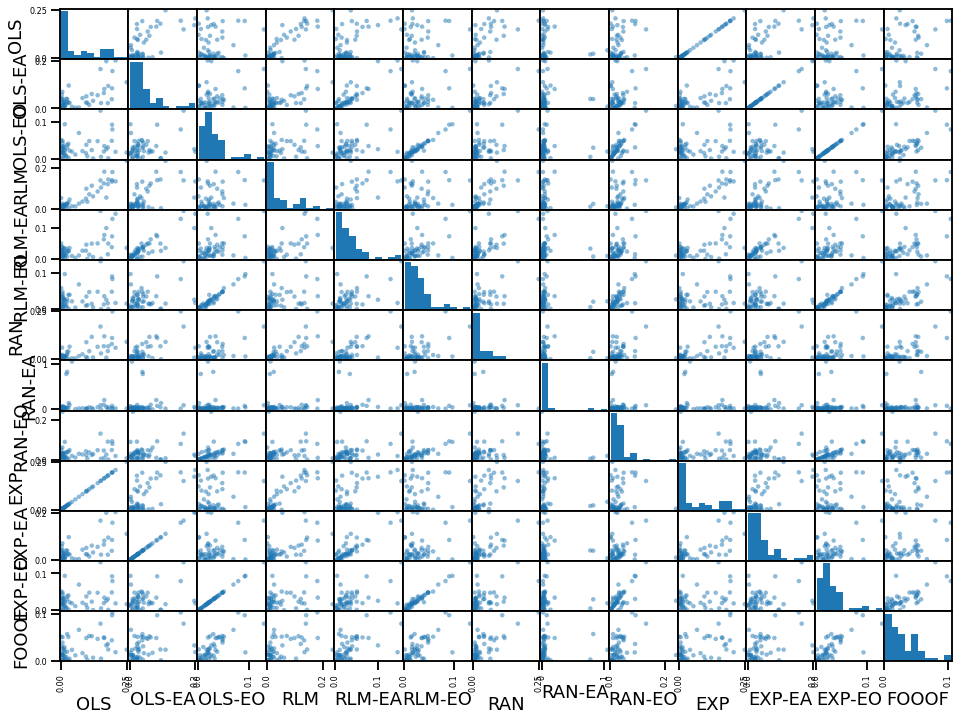

In [24]:
# Plot data distributions and inter-relations
pd.plotting.scatter_matrix(df, figsize=[16, 12]);

In [25]:
# Apply a normal test across fit-error distributions
normalities = df.apply(normaltest)

# Check which results of normal test
nt_df = pd.DataFrame([data[1] for data in normalities.values], index=normalities.index)
nt_df.style.applymap(color_red_or_green)

,0
OLS,0.016168
OLS-EA,0.000001
OLS-EO,0.000001
RLM,0.001976
RLM-EA,0.000000
RLM-EO,0.000001
RAN,0.000000
RAN-EA,0.000000
RAN-EO,0.000000
EXP,0.016168


In [26]:
# Save out simulated fit data to pickle
save_pickle(sims.errs, 'SimFits_test.p', db.sims_path)

In [27]:
# Check available simulated fit results files
sim_files = db.check_files('sims')
f_ind = sim_files.index('SimFits_test.p')

In [29]:
# Load simulated fit results data from pickle file
data = load_pickle(sim_files[f_ind], db.sims_path)
sim_dat = SimFits()
sim_dat.errs = data